<!-- WARNING: THIS FILE WAS AUTOGENERATED! DO NOT EDIT! -->

# Introduction
A key property of quantum systems is entanglement. In order to determine whether a system is entangled or not, we need to find whether its state belongs to the set of separable states. However, fully characterizing this set is extremely hard and we rely on tools such as entanglement witnesses to solve this task. 

Such witnesses often rely on the expectation value of an observable whose result signals the presence of entanglement. For instance, in the case of energy-based witnesses, the expectation value is over the Hamiltonian. In this case, if we are able to find the minimum possible energy within the set of separable states $E_{\text{sep}}$, we can build an entanglement witness in the following way. Let $$\Delta E = \langle H\rangle - E_{\text{sep}}\,,$$ where $\langle H\rangle=\text{Tr}\left[\rho H\right]$ is the energy of an arbitrary state $\rho$. If $\Delta E > 0$, it means that $\rho$ lies within the set of separable states. Conversely, if $\Delta E<0$, the energy obtained with $\rho$ is lower than $E_{\text{sep}}$ and, therefore, $\rho$ lies outside of the set of separable states meaning that it is entangled.

Nevertheless, finding $E_{\text{sep}}$ is, in general, a difficult task. Although there are analytical expressions for some specific cases [[1]](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.71.010301), we usually rely on approximate methods, such as relaxation methods to estimate $E_{\text{sep}}$. In this case, we relax the minimization problem of finding the minimum energy over the set of separable states to, instead, imposing that the states are positive under partial transposition (PPT) [[2]](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.77.1413). The set of PPT states is larger than the set of separable states and, therefore, we obtain a lower bound of $E_{\text{sep}}$. However, the tighter the bound, the better our witness as we can identify more entangled states. 

# Case of study: the physical system

We consider the [`XXHamiltonian`](https://BorjaRequena.github.io/BOUNCE/source/hamiltonian.html#xxhamiltonian) of the form $$H=\sum_{i} J_{i}(\sigma_{i}^x \sigma_{i+1}^x + \sigma_{i}^y \sigma_{i+1}^y) + \sum_{i}B_{i}\sigma_{i}^z\,.$$ In the case of homogeneous field and couplings, $B_i=B, J_i=J\, \forall i$, there have been derived analytical expressions for entanglement witnesses [[1]](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.71.010301) that we use to validate our results. 

# Obtaining exact bounds

In [ ]:
def exact_XX_sep_bound(N, B, J, d):
    "Minimum energy for separable states in the XX model."
    b = B/J/d
    if b <= 2:
        return -d*N*J*(1+b**2/4)
    return -d*N*J*b

Let's start with a simple one-dimensional system. In this case, the PPT criterion is exact and we can quickly recover the exact solutions. 

In [ ]:
N = 6
chain = Chain1D(N)

This Hamiltonian presents a phase transition at $B/J=2$. When the external field dominates, the ground state is separable, whereas it is entangled in the opposite phase. Let's see what we obtain with a separable ground state. 

In [ ]:
b, j = 4, 1
H = XXHamiltonian(chain, b, j)
solver_sep = SdPWitnessSolver()
budget = 185
env = SdPEnvironment(H, solver_sep, budget)

We start with a trivial relaxation (no compatibility constraints) and see what we obtain.

In [ ]:
env.layout

[array([0]), array([1]), array([2]), array([3]), array([4]), array([5])]

In [ ]:
trivial_bound = env.bound
exact_bound = exact_XX_sep_bound(N, b, j, 1)
print(f"The trivial bound is {trivial_bound:.3f} and the exact is {exact_bound:.3f}")

The trivial bound is -36.000 and the exact is -24.000


The trivial bound is far off the exact value. However, we recover the exact value by just imposing two-body compatibility contraints. 

In [ ]:
env.state[:N] = 1
env.layout

[array([0, 1]),
 array([1, 2]),
 array([2, 3]),
 array([3, 4]),
 array([4, 5]),
 array([0, 5])]

In [ ]:
bound = env.bound
print(f"The obtained bound is {bound:.3f} and the exact is {exact_bound:.3f}")

The obtained bound is -24.000 and the exact is -24.000


Furthermore, as we have seen in the previous calculations and in [[3]](https://arxiv.org/abs/2103.03830), these are all the constraints we need to recover the exact ground state energy in this phase. 

In [ ]:
solver_gs = SdPEnergySolver()
gs_energy = solver_gs.solve(H.to_sdp(), env.layout)
print(f"The ground state energy is {gs_energy:.3f}")

The ground state energy is -24.000


Given that the ground state energy matches the separability bound, we can conclude that the ground state is separable!

Let's do a rough exploration of the phase diagram with these methods. 

In [ ]:
bs = np.linspace(0, 4, 21)
energy_sep, energy_gs, exact_sep = [], [], []
for b in tqdm(bs):
    H = XXHamiltonian(chain, b, j)
    energy_sep.append(solver_sep.solve(H.to_sdp(), env.layout))
    energy_gs.append(solver_gs.solve(H.to_sdp(), env.layout))
    exact_sep.append(exact_XX_sep_bound(N, b, j, 1))

  0%|          | 0/21 [00:00<?, ?it/s]

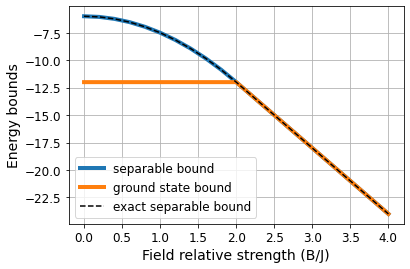

In [ ]:
#| code-fold: true
plt.plot(bs, energy_sep, linewidth=4, label='separable bound')
plt.plot(bs, energy_gs, linewidth=4, label='ground state bound')
plt.plot(bs, exact_sep, '--', color='k', label='exact separable bound')
plt.grid()
plt.legend(fontsize=12)
plt.tick_params(labelsize=12)
plt.xlabel('Field relative strength (B/J)', fontsize=14)
plt.ylabel('Energy bounds', fontsize=14);

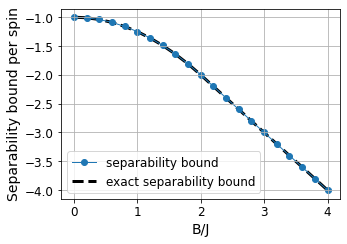

In [ ]:
#| code-fold: true
plt.figure(figsize=(5, 3.5))
plt.plot(bs, np.array(energy_sep)/N, 'o-', linewidth=1, label='separability bound', zorder=1)
plt.plot(bs, np.array(exact_sep)/N, '--', color='k', linewidth=3, label='exact separability bound', zorder=0)
plt.grid()
plt.legend(fontsize=12)
plt.tick_params(labelsize=12)
plt.xlabel('B/J', fontsize=14)
plt.ylabel('Separability bound per spin', fontsize=14);
# plt.savefig("../figures/witness_exact.pdf", bbox_inches="tight");

We observe that both bounds match at $B/J\geq2$, meaning that the ground state in that phase is separable. In the opposite phase, we may be tempted to claim that the ground state is entangled from this plot. While we know it is, the ground state bound is a *lower* bound, meaning that the ground state energy lies beyond the line but we do not know how far it is. From previous results, we also know that this relaxation based on two-body constraints is quite bad for this phase. 

In order to properly assess whether the phase at $B/J<2$ is entangled, we should use a variational method to find the ground state energy of the system. Variational methods provide *upper* bounds and, hence, if the upper bound for the ground state lies below the lower bound for separable states we can confidently say that the ground state is entangled. 

# Beyond analytical solutions

In the previous example above, we have solved a simple system with an analytical solution for the separable bound. In this case, the exact solution is recoverable by simply introducing two-body compatibility constraints in the associated semidefinite program (SdP). Introducing further constraints, we do not obtain any better bound and we simply increase the cost of solving our associated SdP. 

Let us now consider a more challenging scenario in which the Hamiltonian is not homogeneous. Thus, we do not have any analytical proof of reference. In this case, imposing some constraints we may obtain better bounds than with others of similar cost. Therefore, it is crucial to properly explore the constraint space to find the best possible relaxation within some computational limitations. 

For this experiment, we consider a square lattice with random fields and couplings.

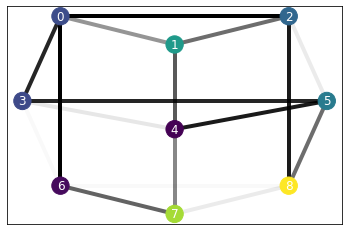

In [ ]:
N, M = 3, 3
graph = SquareLattice(N, M)
np.random.seed(0)
b, j = np.random.rand(N*M), np.random.rand(N*M)
H = XXHamiltonian(graph, b, j)
H.draw()

The goal now is to find the best possible separable bound. Since the number of possible constraints is very large, we restrict our search to exclusively use single body, two-body and three-body constraints, despite the computational budget. 

In [ ]:
solver_sep = SdPWitnessSolver()
budget = 490
max_size = 3

In [ ]:
env = SdPEnvironment(H, solver_sep, budget, max_basis_size=3)
env.show_constraints()

2: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
3: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0]


Let's see first the bound we obtain simply using two-body constraints.

In [ ]:
env.state[:18] = 1
env.show_constraints()
print(f"The separable bound is {env.bound:.4f}")

2: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
3: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0]
The separable bound is -9.6186


## Quick test
In such a random system, the contribution of larger constraints can vary significantly. We perform a simple test in which we allocate all the possible three-body constraints alone filling the rest with two-body ones. 

In [ ]:
for i in tqdm(range(18, len(env.state))):
    env.reset()
    env.state[:18] = 1
    env.state[i] = 1
    print(f"{env.layout_basis[i]} {env.bound:.4f}")

  0%|          | 0/42 [00:00<?, ?it/s]

[0 1 3] -9.6186
[0 1 2] -8.9952
[0 1 4] -9.6186
[0 1 6] -9.6186
[0 1 7] -9.6186
[0 2 3] -9.6186
[0 3 4] -9.6186
[0 3 6] -9.5821
[0 3 5] -9.6186
[1 2 4] -9.6186
[1 2 5] -9.6186
[1 2 7] -9.6186
[1 2 8] -9.6186
[1 3 4] -9.6186
[1 4 5] -9.6186
[1 4 7] -9.5038
[0 2 5] -9.6186
[0 2 6] -9.6186
[0 2 8] -9.6186
[2 4 5] -9.6186
[2 3 5] -9.6186
[2 5 8] -9.4889
[3 4 6] -9.6186
[3 4 5] -9.4597
[3 4 7] -9.6186
[3 5 6] -9.6186
[3 6 7] -9.6186
[3 6 8] -9.6186
[4 5 7] -9.6186
[4 5 8] -9.6186
[4 6 7] -9.6186
[4 7 8] -9.6186
[3 5 8] -9.6186
[5 7 8] -9.6186
[5 6 8] -9.6186
[0 6 7] -9.6186
[6 7 8] -9.5872
[1 6 7] -9.6186
[0 6 8] -9.6186
[1 7 8] -9.6186
[2 7 8] -9.6186
[2 6 8] -9.6186


Most of them barely have any effect, while just a few have a very high impact. Let's explore this with an agent and see what is the best possible bound it can find. 

In [ ]:
env = SdPEnvironment(H, solver_sep, budget, max_basis_size=3)

In [ ]:
dqn = DQNTrainer(env)

In [ ]:
results_dqn = dqn.train(300, time_steps=15)

  0%|          | 0/300 [00:00<?, ?it/s]

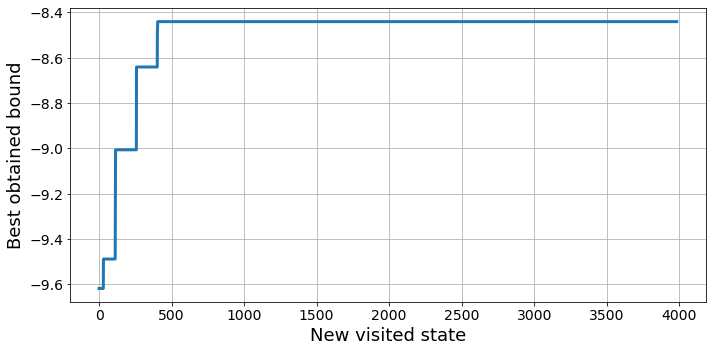

In [ ]:
plot_exploration(results_dqn['exploration'], expl_optims=False)

## Exhaustive search

Let's now throw several agents for various budgets and see what are the best separable bounds that we can find.

In [ ]:
solver_sep = SdPWitnessSolver()
budgets = [390, 470, 490, 540]
eps_decays = [0.98, 0.98, 0.99, 0.99]
episodes = 600
n_agents, n_jobs = 50, 15
results_dqn = []
for budget, decay in tqdm(zip(budgets, eps_decays)):
    env = SdPEnvironment(H, solver_sep, budget, max_basis_size=3, initial_size=2)
    dqn = DQNTrainer(env, n_agents=n_agents, n_jobs=n_jobs, eps_decay=decay, batch_size=256)
    results_budget = dqn.train(episodes, time_steps=15, ckp=2)
    results_dqn.append(results_budget)
    
#     with open(f'../benchmarks/witness_lattice_dqn_{budget}.pkl', 'wb') as f:
#         pickle.dump(results_budget, f, protocol=pickle.HIGHEST_PROTOCOL)

0it [00:00, ?it/s]

In [ ]:
# with open('../benchmarks/witness_lattice_dqn.pkl', 'wb') as f:
#     pickle.dump(results_dqn, f, protocol=pickle.HIGHEST_PROTOCOL)

## Result analysis

First of all, we start by loading the data.

In [ ]:
with open('../benchmarks/witness_lattice_dqn.pkl', 'rb') as f:
    results_dqn = pickle.load(f)

### Exploration results
Now we can look at an exploration example for a given budget to get a better understanding of the optimization process.

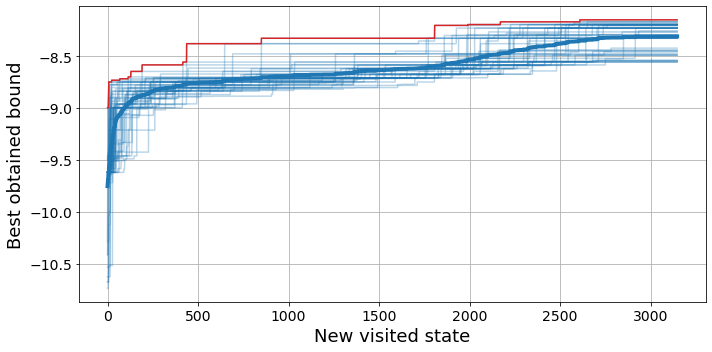

In [ ]:
#| code-fold: true
plot_exploration(results_dqn[2]['exploration'], expl_optims=False, highlight_max=True)

Let's plot the results for the different budgets

In [ ]:
from bounce.utils import arrange_shape, best_so_far

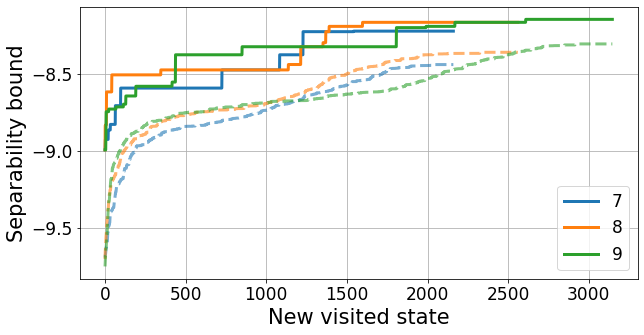

In [ ]:
#| code-fold: true
labels = [7, 8, 9, 10]
fig, ax = plt.subplots(figsize=(10, 5))
for i, results in enumerate(results_dqn[:-1]):
    bounds = arrange_shape(results['exploration']['bounds'])
    best_bounds = best_so_far(bounds).T
    best_mean, best_max = np.mean(best_bounds, axis=-1), np.max(best_bounds, axis=-1)
    
    ax.plot(best_max, color=f'C{i}', linewidth=3, label=labels[i])
    ax.plot(best_mean, color=f'C{i}', linewidth=3, linestyle='dashed', alpha=0.6)
    
ax.grid()
ax.legend(fontsize=17)
ax.tick_params(labelsize=17)
ax.set_ylabel("Separability bound", fontsize=21)
ax.set_xlabel("New visited state", fontsize=21)
plt.savefig("../figures/witnesses_budget.pdf", bbox_inches='tight')

We can see a quick early raise in the best obtained bound followed by a stagnation period. This is the natural random exploration process, which is quite inefficient. Then, after about 1500 states, we observe a collective raise in the best bound, which is when the agents start exploiting the gathered knowledge to their advantage. This lines up with the end of the exploration phase, as we exponentially decrease the value of $\varepsilon$ in the policy, reaching its minimum between 100 and 200 episodes.

We can have a look at the best layout that we have found for each budget. 

In [ ]:
best_by_budget = []
for results in results_dqn:
    best_bound = -np.infty
    for env in results['exploration']['envs']:
        bound, layout = env.best[0], env.best_layout
        if bound > best_bound:
            best_bound = deepcopy(bound)
            best_layout = deepcopy(layout)
    best_by_budget.append((best_bound, best_layout))

In [ ]:
best_by_budget

[(-8.225026975813115,
  [array([0, 6]),
   array([0, 1, 2]),
   array([0, 3, 5]),
   array([1, 4, 7]),
   array([0, 2, 5]),
   array([2, 5, 8]),
   array([3, 4, 5]),
   array([6, 7, 8])]),
 (-8.167977031639149,
  [array([0, 1, 2]),
   array([0, 3, 6]),
   array([0, 3, 5]),
   array([1, 4, 7]),
   array([0, 2, 5]),
   array([2, 5, 8]),
   array([3, 4, 5]),
   array([6, 7, 8])]),
 (-8.148677351430782,
  [array([3, 6]),
   array([0, 1, 2]),
   array([0, 1, 6]),
   array([0, 2, 3]),
   array([1, 4, 7]),
   array([2, 3, 5]),
   array([2, 5, 8]),
   array([3, 4, 5]),
   array([6, 7, 8]),
   array([1, 6, 7])])]

::: {.callout-note}
Yep, this print right above here looks terrible and the information is rather hidden. We have used it to draw Figure 9 (b) in [our paper](https://arxiv.org/abs/2103.03830), better have a look there! 
:::

### Constraint statistics: frequency
In order to get a deeper understanding of the problem, we can look at the similarities between the best results obtained by each agent. This way, we can see which are the most important constraints in our problem. 

In [ ]:
def element2str(element): return ''.join([str(i) for i in element])
element_index = {element2str(element): k for k, element in enumerate(env.layout_basis)}

In [ ]:
hist_by_budget = []
for results in results_dqn[:-1]:
    element_bound = {k: [] for k in element_index.keys()}
    for env in results['exploration']['envs']:
        bound, layout = env.best[0], env.best_layout
        for basis_element in layout:
            element_bound[element2str(basis_element)] += [bound]
    hist_by_budget.append(element_bound)

Now we can look at the most used constraints. For instance, for the largest budget.

In [ ]:
idx_budget = -1
bounds_by_element = hist_by_budget[idx_budget]
x = list(element_index.keys())
counts = np.array([len(bounds_by_element[k]) for k in x])
freq = counts/counts.sum()

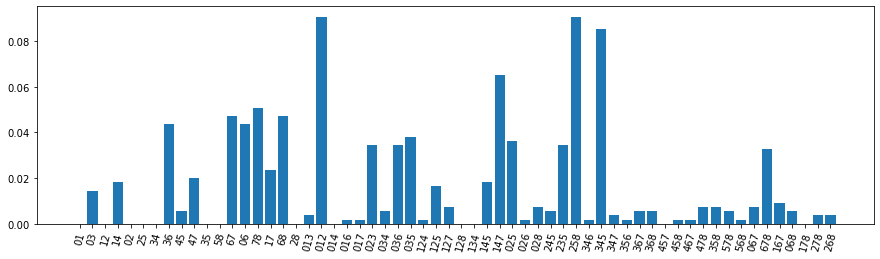

In [ ]:
#| code-fold: true
plt.figure(figsize=(15, 4))
plt.bar(x, freq)
plt.xticks(rotation=75);

There are some clear 3-body terms that are overrepresented with respect to the rest: the $[0, 1, 2]$, the $[2, 5, 8]$ and the $[3, 4, 5]$.

We can look even further and check the frequency that every 2-body term is captured either by itself or by another 3-body term.

In [ ]:
counts_link = {}
for link in x[:18]:
    counts_link[link] = sum([counts[element_index[k]] for k in element_index.keys()
                             if np.all([l in k for l in link])])
counts_link = {k: v/max(counts_link.values()) for k, v in counts_link.items()}

<BarContainer object of 18 artists>

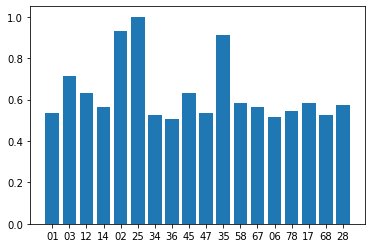

In [ ]:
#| code-fold: true
plt.bar(list(counts_link.keys()), list(counts_link.values()));

Again, we see a few elements that appear more often in the best obtained relaxations. We can bring the analysis even further by looking only at the **top performing agents**. Let's do it!

In [ ]:
bounds = [env.best[0] for env in results_dqn[idx_budget]['exploration']['envs']]
idx_top = np.argsort(bounds)[::-1]

In [ ]:
top = 10
element_bound = {k: [] for k in element_index.keys()}
for i in idx_top[:top]:
    env = results_dqn[idx_budget]['exploration']['envs'][i]
    bound, layout = env.best[0], env.best_layout
    for basis_element in layout:
        element_bound[element2str(basis_element)] += [bound]

In [ ]:
counts_top = np.array([len(element_bound[k]) for k in x])
freq_top = counts/counts.sum()

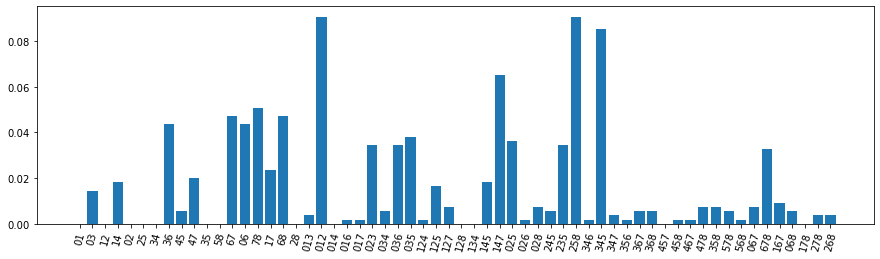

In [ ]:
#| code-fold: true
plt.figure(figsize=(15, 4))
plt.bar(x, freq_top)
plt.xticks(rotation=75);

In [ ]:
counts_link = {}
for link in x[:18]:
    counts_link[link] = sum([counts_top[element_index[k]] for k in element_index.keys()
                             if np.all([l in k for l in link])])
counts_link = {k: v/max(counts_link.values()) for k, v in counts_link.items()}

<BarContainer object of 18 artists>

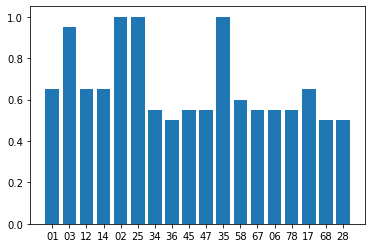

In [ ]:
#| code-fold: true
plt.bar(list(counts_link.keys()), list(counts_link.values()));

We do not see any major differences with the previous analysis, meaning that the agents have consistently found similar relaxations. The main difference that we observe is in the representation of the $[0, 3]$ term, which is clearly overrepresented by the top 10 performing agents, and it was just shy above the baseline in the previous analysis.

### Constraint statistics: bounds
We can also look at the relationship between each basis element and the obtained bound. This way, we can see whether a certain element results in higher energy bounds on average.

In [ ]:
bound_2body = -9.6186 # From before
bound_avg = np.array([np.mean(bounds_by_element[k]) for k in x])
bound_max = np.array([np.max(bounds_by_element[k]) 
                      if len(bounds_by_element[k]) > 0 else np.nan for k in x])
bound_gain = bound_avg - bound_2body

We start by looking at every single energy bound obtained with a layout that contained each basis element.

In [ ]:
x_scatter = [[k]*count for k, count in zip(x, counts)]
x_scatter = [s for sublist in x_scatter for s in sublist]
y_scatter = [s for k in x for s in bounds_by_element[k]]

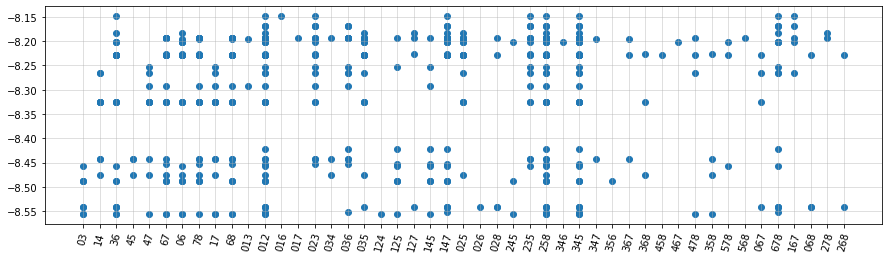

In [ ]:
#| code-fold: true
plt.figure(figsize=(15, 4))
plt.scatter(x_scatter, y_scatter)
plt.grid(alpha=0.5)
plt.xticks(rotation=75);

In this plot, top row of points corresponds to the best obtained energy bound with the layout $[[3, 6], [0, 1, 2], [0, 1, 6], [0, 2, 3], \dots]$. Interestingly, the term $[0, 1, 6]$ only appears in the best layout.

However, with this visualization, it is hard to determine the average performance associated to each element. To get a better picture, we can compute the average energy gain over the full 2-body constraint baseline.

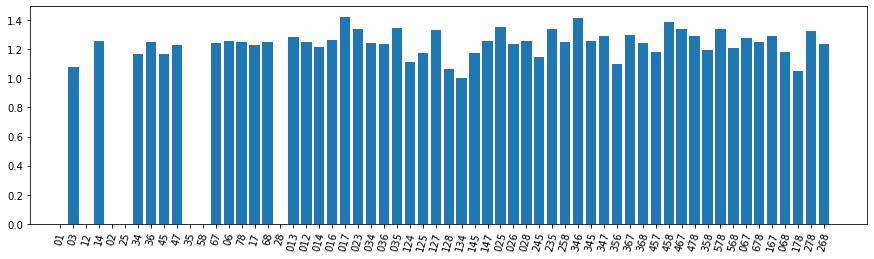

In [ ]:
#| code-fold: true
plt.figure(figsize=(15, 4))
plt.bar(x, bound_gain)
plt.xticks(rotation=75);

It's still a bit hard to find the relationship between the different basis elements and the best bounds. Let's build a regressor that tries to predict the bound we will obtain with a given layout and inspect its feature importances. 

::: {.callout-warning} 
## Work in progress
Yeh, well... This is awkward. We have not gathered enough time and energy to do this. If you want to have a look at it together just send us an email.
:::

# References

[1] G. Tóth. [Entanglement Witnesses in Spin Models](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.71.010301). *Physical Review A* **71** 010301 (2005).

[2] A. Peres. [Separability Criterion for Density Matrices](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.77.1413). *Physical Review Letters* **77** 1413 (1996).

[3] B. Requena, G. Muñoz-Gil, M. Lewenstein, V. Dunjko, J. Tura. [Certificates of quantum many-body properties assisted by machine learning](https://arxiv.org/abs/2103.03830). *arXiv:2103.03830 (2021)*